In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import sys

In [3]:
sys.path.append('../..')

In [4]:
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes

### Goal: Plot trial-averaged, possibly time aligned smoothed trajectories for single neurons with particularly highly loadings

#### Sabes

In [5]:
start_times = {'indy_20160426_01': 0,
               'indy_20160622_01':1700,
               'indy_20160624_03': 500,
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161011_03': 0,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }

In [6]:
#data_path = '/mnt/sdb1/nc_data/sabes'
data_path = '/mnt/Secondary/data/sabes'

In [7]:
# with open('/mnt/sdb1/nc_data/sabes_decoding_df.dat', 'rb') as f:
#     sabes_df = pickle.load(f)
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)

In [8]:
data_files = np.unique(sabes_df['data_file'].values)

In [14]:
# Try the raw leverage scores instead
loadings_l = []

for i, data_file in tqdm(enumerate(data_files)):
        loadings = []
        for dimreduc_method in ['DCA', 'KCA', 'LQGCA', 'PCA']:
            loadings_fold = []
            for fold_idx in range(5):            
                df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=fold_idx, dim=6, dimreduc_method=dimreduc_method)
                if dimreduc_method == 'LQGCA':
                    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 5})
                V = df_.iloc[0]['coef']
                if dimreduc_method == 'PCA':
                    V = V[:, 0:2]        
                loadings_fold.append(calc_loadings(V))

            # Average loadings across folds
            loadings.append(np.mean(np.array(loadings_fold), axis=0))

        for j in range(loadings[0].size):
            d_ = {}
            d_['data_file'] = data_file
            d_['DCA_loadings'] = loadings[0][j]
            d_['KCA_loadings'] = loadings[1][j]
            d_['FCCA_loadings'] = loadings[2][j]
            d_['PCA_loadings'] = loadings[3][j]
            d_['nidx'] = j
            loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)

28it [00:02, 13.62it/s]


In [15]:
# For each data file, find the top 5 neurons that are high in one method but low in all others
top_neurons_l = []
n = 10
for i, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(loadings_df, data_file=data_file)
    DCA_ordering = np.argsort(df_['DCA_loadings'].values)
    KCA_ordering = np.argsort(df_['KCA_loadings'].values)
    FCCA_ordering = np.argsort(df_['FCCA_loadings'].values)
    PCA_ordering = np.argsort(df_['PCA_loadings'].values)
    
    rank_diffs = np.zeros((DCA_ordering.size, 6))
    for j in range(df_.shape[0]):
        rank_diffs[j, 0] = list(DCA_ordering).index(j) - list(KCA_ordering).index(j)
        rank_diffs[j, 1] = list(DCA_ordering).index(j) - list(FCCA_ordering).index(j)
        rank_diffs[j, 2] = list(DCA_ordering).index(j) - list(PCA_ordering).index(j)
        
        rank_diffs[j, 3] = list(KCA_ordering).index(j) - list(FCCA_ordering).index(j)
        rank_diffs[j, 4] = list(KCA_ordering).index(j) - list(PCA_ordering).index(j)
        
        rank_diffs[j, 5] = list(FCCA_ordering).index(j) - list(PCA_ordering).index(j)

    # Find the top 5 neurons according to all pairwise high/low orderings
    top_neurons = np.zeros((2, n)).astype(int)

    # DCA_top = set([])
    # KCA_top = set([])
    FCCA_top = []
    PCA_top = []

    idx = 0
    while not np.all([len(x) >= n for x in [FCCA_top, PCA_top]]):
        idx += 1
        # Take neurons from the top ordering of each method. Disregard neurons that 
        # show up in all methods
        # top_DCA = DCA_ordering[-idx]        # top_DCA = DCA_ordering[-idx]

        top_FCCA = FCCA_ordering[-idx]
        top_PCA = PCA_ordering[-idx]

        if top_FCCA != top_PCA:
            if top_FCCA not in PCA_top:
                FCCA_top.append(top_FCCA)
            if top_PCA not in FCCA_top:
                PCA_top.append(top_PCA)
        else:
            continue

    top_neurons[0, :] = FCCA_top[0:n]
    top_neurons[1, :] = PCA_top[0:n]

    # top_neurons[0, :] = DCA_ordering[-n:]
    # top_neurons[1, :] = KCA_ordering[-n:]
    # top_neurons[2, :] = FCCA_ordering[-n:]
    # top_neurons[3, :] = PCA_ordering[-n:]




    # for j in range(6):
        # top_neurons[2*j, :] = np.sort(rank_diffs[:, j])[-n:]
        # top_neurons[2*j + 1, :] = np.sort(rank_diffs[:, j])[0:n]

        # Highest loadings


    top_neurons_l.append({'data_file':data_file, 'rank_diffs':rank_diffs, 'top_neurons': top_neurons}) 

28it [00:00, 65.87it/s]


In [16]:
top_neurons_df = pd.DataFrame(top_neurons_l)

In [17]:
top_neurons_df.iloc[0]['top_neurons']

array([[ 15,  42, 176,  13,  70, 119, 103,  44,  92,  75],
       [106, 111, 132,   6, 121, 100, 117,  77,   0, 134]])

In [18]:
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import StandardScaler

Processing spikes


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.30it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 13.93it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 41.82it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 44.38it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 37.31it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.54it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 46.16it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31.27it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29.02it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 22.56it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 36.11it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29.87it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 33.82it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.34it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34.37it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.61it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31.46it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 20.38it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 37.40it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 33.16it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29.01it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.74it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 30.69it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 25.39it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 19.86it/s]
../../segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


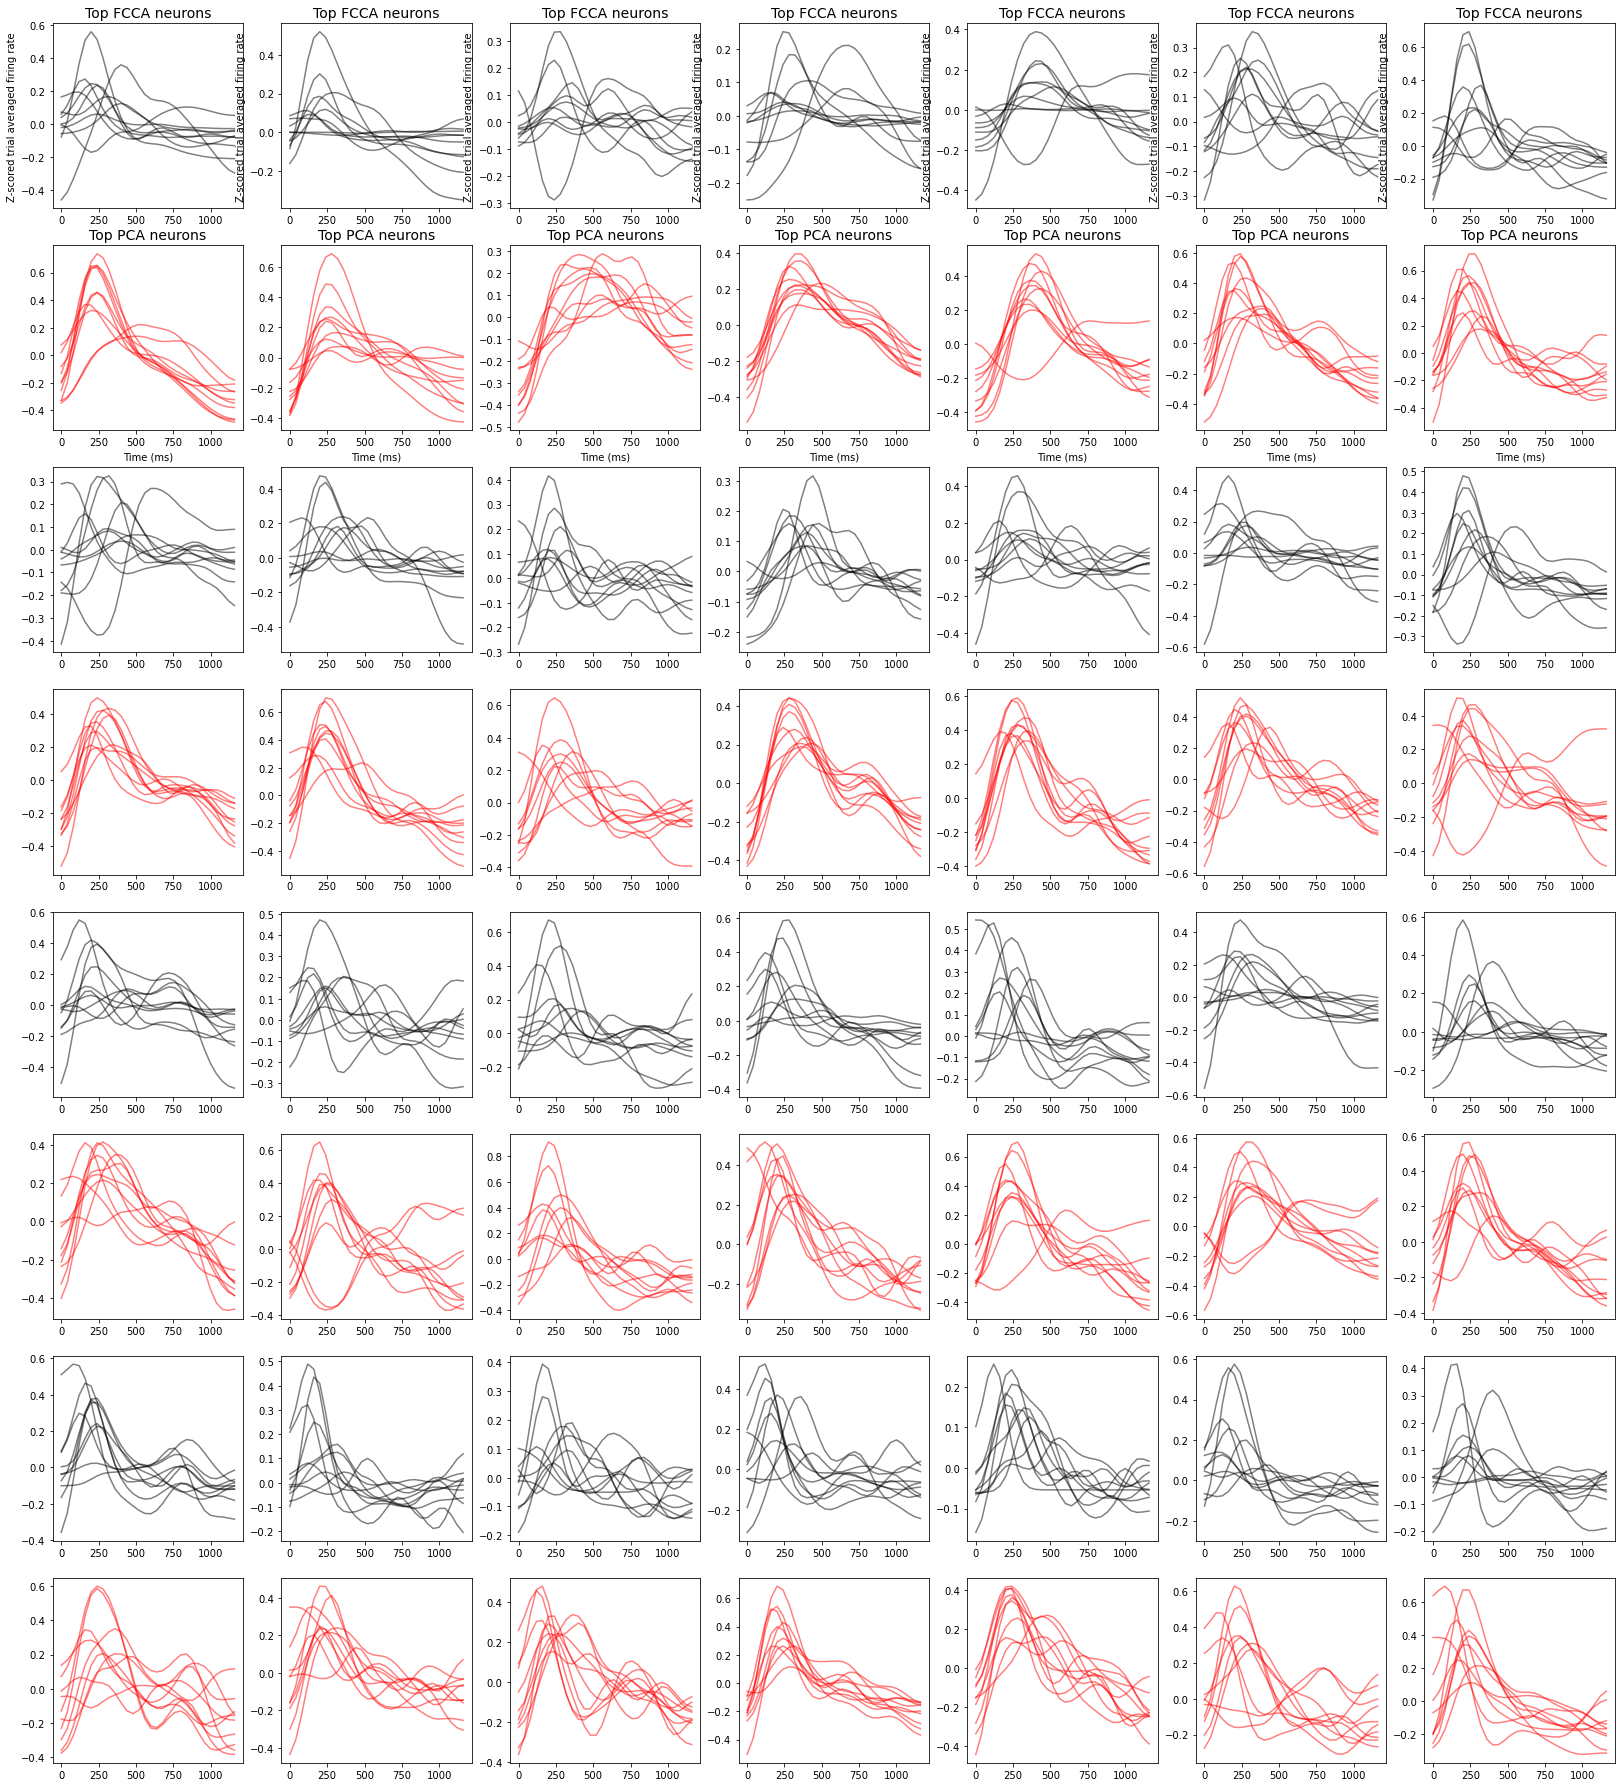

In [19]:
ndf = 7
fig, ax = plt.subplots(2 * 4, ndf, figsize=(4*ndf, 32))

for h, data_file in enumerate(data_files):

    df_ = apply_df_filters(top_neurons_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
    dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])
    
    T = 30
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]

    # (Bin size 50 ms)
    time = 40 * np.arange(T)

    for i in range(2):
        for j in range(n):
            tn = df_.iloc[0]['top_neurons'][i, j]    
            try:
                x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                            for idx in valid_transitions])
            except:
                pdb.set_trace()
            
            # Mean subtract
#            x_ -= np.mean(x_, axis=1, keepdims=True)
            try:
                x_ = StandardScaler().fit_transform(x_.T).T
                x_ = gaussian_filter1d(x_, sigma=2)
                x_ = np.mean(x_, axis=0)

                if i == 0:
                    ax[2 * (h//7) + i, h % 7].plot(time, x_, 'k', alpha=0.5)
                if i == 1:
                    ax[2 * (h//7) + i, h % 7].plot(time, x_, 'r', alpha=0.5)
            except:
                continue

for i in range(ndf):
    ax[0, i].set_title('Top FCCA neurons', fontsize=14)
    ax[1, i].set_title('Top PCA neurons', fontsize=14)
    ax[1, i].set_xlabel('Time (ms)')
    ax[0, i].set_ylabel('Z-scored trial averaged firing rate')

# fig.savefig('psth_indy.pdf', bbox_inches='tight', pad_inches=0)

### Cross-correlation heatmap

In [13]:
T = 30
# (Bin size 50 ms)
time = 50 * np.arange(T)
cross_covs = np.zeros((len(data_files), 2, n, n, time.size))
cross_covs_01 = np.zeros((len(data_files), 2, n, n, time.size))

for h, data_file in enumerate(data_files):
    df_ = apply_df_filters(top_neurons_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
    dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])
    
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]


    for i in range(2):
        
        # Store trajectories for subsequent pairwise analysis
        x = np.zeros((n, time.size))

        for j in range(n):
            tn = df_.iloc[0]['top_neurons'][i, j]    
            x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                        for idx in valid_transitions])
            
            x_ = StandardScaler().fit_transform(x_.T).T
            x_ = gaussian_filter1d(x_, sigma=2)
            x_ = np.mean(x_, axis=0)

            # Put on a 0-1 scale
            x[j, :] = x_

        for j in range(n):
            for k in range(n):
                cross_covs[h, i, j, k] = np.correlate(x[j], x[k], mode='same')
                cross_covs_01[h, i, j, k] = np.correlate(x[j]/np.max(x[j]), x[k]/np.max(x[k]), mode='same')

Processing spikes


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 30.82it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 42.89it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 42.74it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 24.83it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34.14it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 45.06it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34.73it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34.45it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 26.44it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.39it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 27.18it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 32.43it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.23it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 25.62it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 32.55it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29.34it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 21.34it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 33.41it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 21.84it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34.14it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 25.67it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.62it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 21.51it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 20.41it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [58]:
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

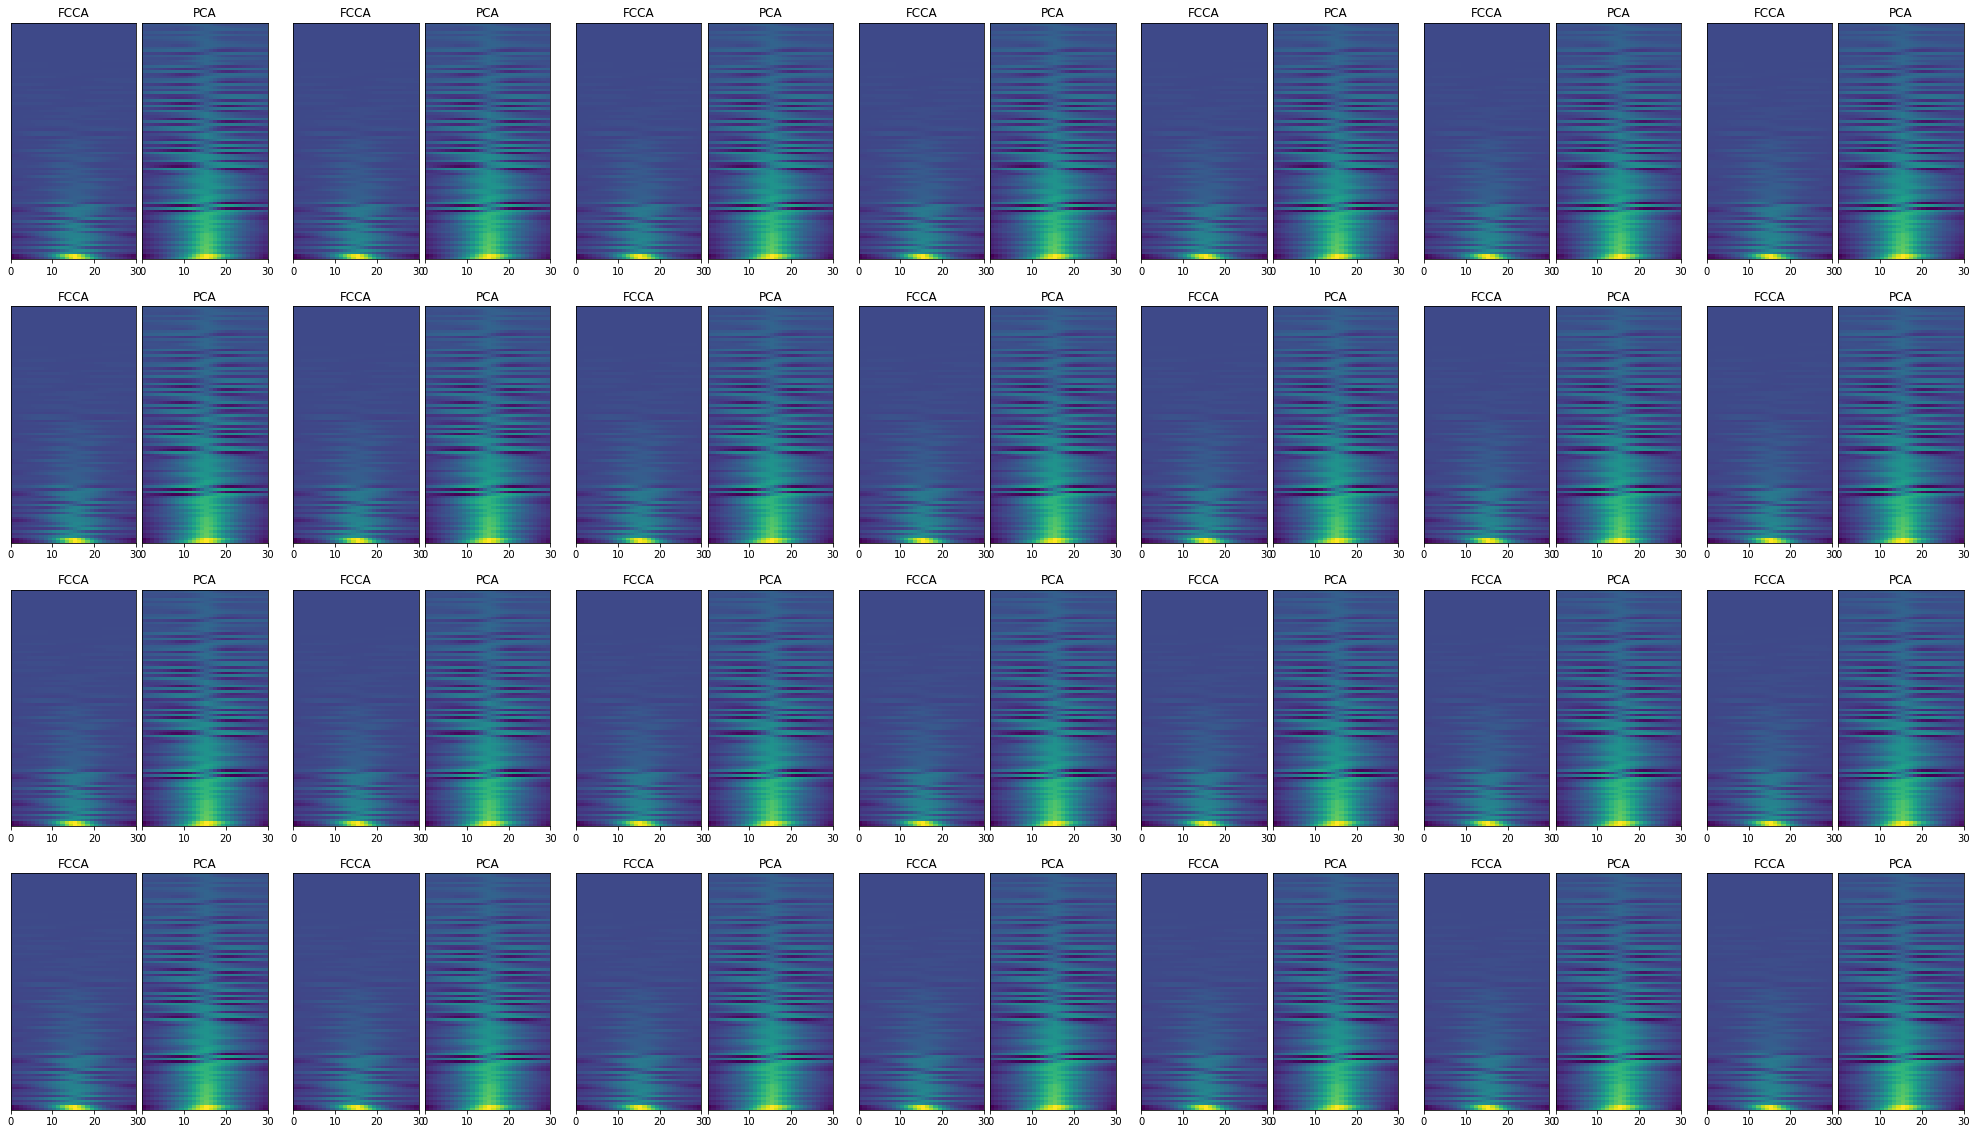

In [97]:
# Plot the pairwise cross-correlations as a sequence of 2D curves
n_df = 7
#fig, ax = plt.subplots(2 * 4, ndf, figsize=(4*ndf, 32))
fig = plt.figure(figsize=(5*7, 5*4))
gs = GridSpec(4, 7, hspace=0.2, wspace=0.1)
# Sort by the time of maximum cross-correlation
# cc_norm = np.divide(cross_covs, np.max(cross_covs, axis=-1))
cc_norm = cross_covs
# Reshape into a sequence so we can sort along the axis of pairwise cross-correlation 
cc_offdiag = np.zeros((cross_covs.shape[0], cross_covs.shape[1], cross_covs.shape[2] * cross_covs.shape[3] - cross_covs.shape[2], cross_covs.shape[-1]))
idx = 0
for i in range(10):
    for j in range(10):
        if i == j:
            continue
        cc_offdiag[:, :, idx, :] = cc_norm[:, :, i, j, :]
        idx += 1
# references for sharing axes
ax_obj = np.zeros(cc_offdiag.shape[0], dtype='object')
for h in range(cc_offdiag.shape[0]):
    cols = ['k', 'r']
    titles = ['FCCA', 'PCA']
    sgs = gs[np.unravel_index(h, (4, 7))].subgridspec(1, 2, wspace=0.05, hspace=0.0)
    for i in range(2):
        # Sort by max cross-cov
        ordering = np.argsort(np.argmax(cc_offdiag[0, i, :, :], axis=-1))
        # #ax = fig.add_subplot(gs[2 * (h//7) + i, h % 7], projection='3d')
        #     ax = fig.add_subplot(gs[2 * (h//7) + i, h % 7])
        #     ax_obj[h] = ax
        # else:
        #     ax = fig.add_subplot(gs[2 * (h//7) + i, h % 7], sharex=ax_obj[h])
        if i == 0:
            ax = fig.add_subplot(sgs[i])
            ax_obj[h] = ax
        else:
            ax = fig.add_subplot(sgs[i], sharey=ax_obj[h])
            ax.set_yticks([])
        ax.pcolor(cc_offdiag[0, i, ordering])
        ax.set_title(titles[i])

        # x-axis label, y-axis label, colormap...        

        # ax.set_aspect('equal')
        # for idx in range(cc_offdiag.shape[2]):
        #     ax.plot(idx * np.ones(30), np.arange(30), cc_offdiag[0, i, ordering[idx], :], cols[i], alpha=0.5)
    # gs.update(left=0.55, right=0.98, hspace=0.05)

# fig.tight_layout()

In [28]:
# Sorted by time of max (normalized cross-cov)


In [14]:
# Significance tests
bin_width = 50
# Reshape into a sequence so we can sort along the axis of pairwise cross-correlation 
cc_mag = np.zeros((cross_covs.shape[0], cross_covs.shape[1], cross_covs.shape[2] * cross_covs.shape[3] - cross_covs.shape[2], cross_covs.shape[-1]))
cc_tau = np.zeros((cross_covs.shape[0], cross_covs.shape[1], cross_covs.shape[2] * cross_covs.shape[3] - cross_covs.shape[2], cross_covs.shape[-1]))

idx = 0
for i in range(10):
    for j in range(10):
        if i == j:
            continue
        cc_mag[:, :, idx, :] = cross_covs[:, :, i, j, :]
        cc_tau[:, :, idx, :] = cross_covs_01[:, :, i, j, :]
        idx += 1

tau_max = np.zeros((cc_tau.shape[0], cc_tau.shape[1], cc_tau.shape[2]))
mag = np.zeros((cc_mag.shape[0], cc_tau.shape[1], cc_tau.shape[2]))

# references for sharing axes
for h in range(cc_tau.shape[0]):
    for i in range(2):
        # Sort by max cross-cov. Impart the correct units
        tau_max[h, i] = bin_width * (np.sort(np.argmax(cc_tau[h, i, :, :], axis=-1)) - T//2)
mag = np.max(cc_mag, axis=-1)

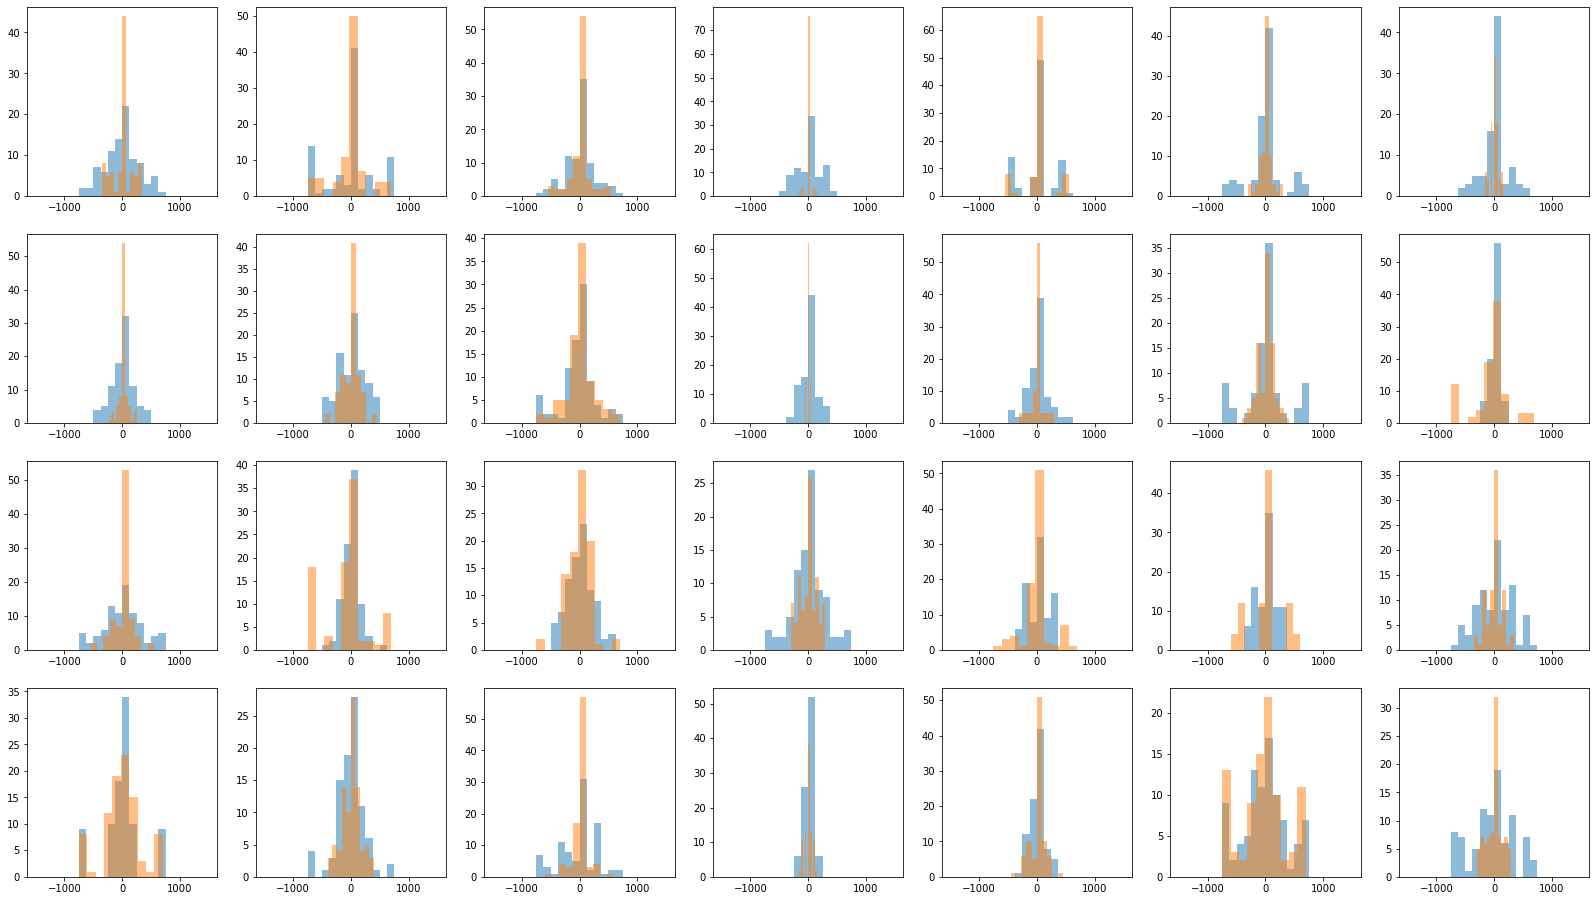

In [15]:
# Plot the histograms
fig, ax = plt.subplots(4, 7, figsize=(28, 16))
for i in range(28):
    a = ax[np.unravel_index(i, (4, 7))]
    a.hist(tau_max[i, 0], alpha=0.5, bins=np.linspace(-1500, 1500, 25))
    a.hist(tau_max[i, 1], alpha=0.5)

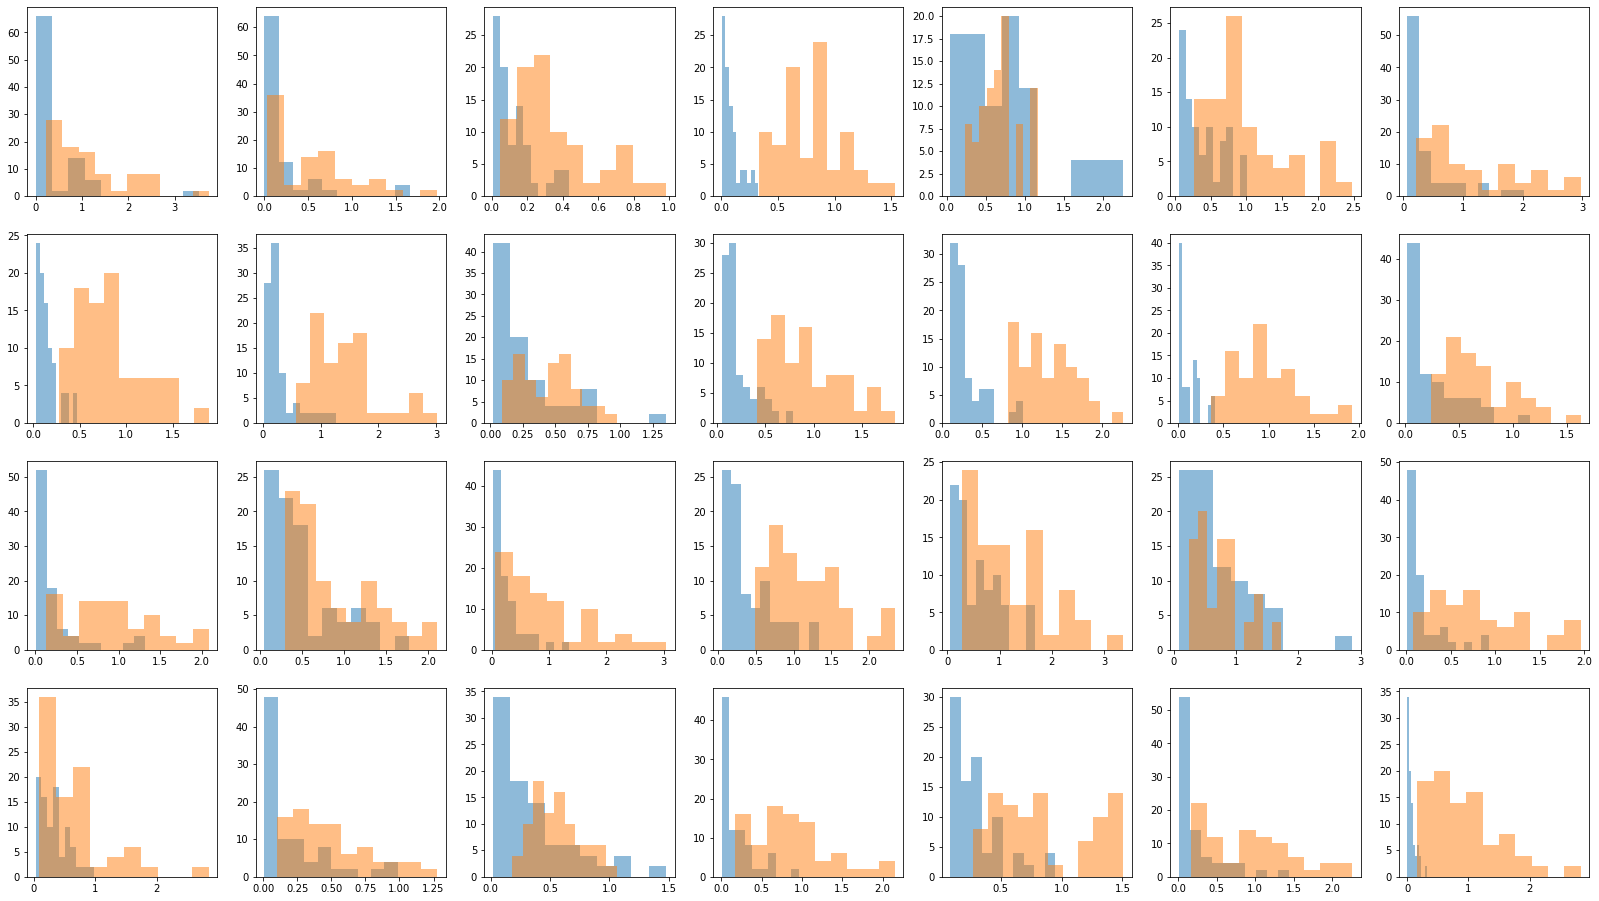

In [35]:
# Plot the histograms
fig, ax = plt.subplots(4, 7, figsize=(28, 16))
for i in range(28):
    a = ax[np.unravel_index(i, (4, 7))]
    a.hist(mag[i, 0], alpha=0.5)
    a.hist(mag[i, 1], alpha=0.5)

In [17]:
from npeet.entropy_estimators import entropy

In [20]:
tau_max.shape

(28, 2, 90)

In [36]:
# How does the choice of k affect the entropy estimation?
tau_h1 = [entropy(tau_max[idx, 0, :][:, np.newaxis], k=4) for idx in range(tau_max.shape[0])]
tau_h2 = [entropy(tau_max[idx, 1, :][:, np.newaxis], k=4) for idx in range(tau_max.shape[0])]

avg_mag1 = np.mean(mag[:, 0, :], axis=-1)
avg_mag2 = np.mean(mag[:, 1, :], axis=-1)

[Text(1, 0, 'FCCA'), Text(2, 0, 'PCA')]

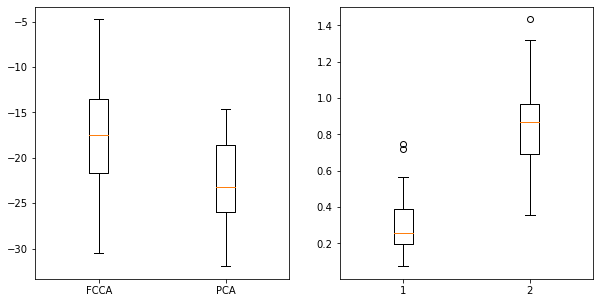

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot([tau_h1, tau_h2])
ax[1].boxplot([avg_mag1, avg_mag2])
ax[0].set_xticklabels(['FCCA', 'PCA'])

In [ ]:
# Boxplots across recording sessions



In [ ]:
# Write a script that does all this analysis automatically so we may 

### Shift Warping

In [14]:
from affinewarp import ShiftWarping

In [15]:
import itertools

In [18]:
maxlags = [0.1, 0.25]
smoothness_reg_scale = [0, 1, 3]
l2_reg_scale = [1e-7]


df_ = apply_df_filters(top_neurons_df, data_file=data_file)
dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=True)
dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])

T = 30
t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

param_combs = list(itertools.product(maxlags, smoothness_reg_scale, l2_reg_scale))

warp_losses = np.zeros((2, n, len(param_combs)), dtype=np.object)

for i in range(2):
    for j in range(n):
        tn = df_.iloc[0]['top_neurons'][i, j]    
        x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                    for idx in valid_transitions])
        
        # Mean subtract
        x_ = gaussian_filter1d(x_, sigma=2, axis=0)
        
        x_ -= np.mean(x_, axis=1, keepdims=True)
        x_ /= np.std(x_, axis=1, keepdims=True)


        for k, param_comb in tqdm(enumerate(param_combs)):
            swarp = ShiftWarping(maxlag=param_comb[0],  smoothness_reg_scale=param_comb[1], l2_reg_scale=param_comb[2])
            try:
                swarp.fit(x_[..., np.newaxis], iterations=20)
                warp_losses[i, j, k] = swarp.loss_hist
            except:
                warp_losses[i, j, k] = np.nan
        

Processing spikes


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
Loss: 0.82: 100%|██████████| 20/20 [00:00<00:00, 1068.00it/s]
6it [00:00, 22.61it/s]
Loss: 0.78: 100%|██████████| 20/20 [00:00<00:00, 791.98it/s]
6it [00:00, 42.91it/s]
Loss: 0.87: 100%|██████████| 20/20 [00:00<00:00, 902.86it/s]
6it [00:00, 46.79it/s]
Loss: 0.91: 100%|██████████| 20/20 [00:00<00:00, 786.23it/s]
6it [00:00, 47.09it/s]
Loss: 0.79: 100%|██████████| 20/20 [00:00<00:00, 1131.68it/s]
6it [00:00, 46.15it

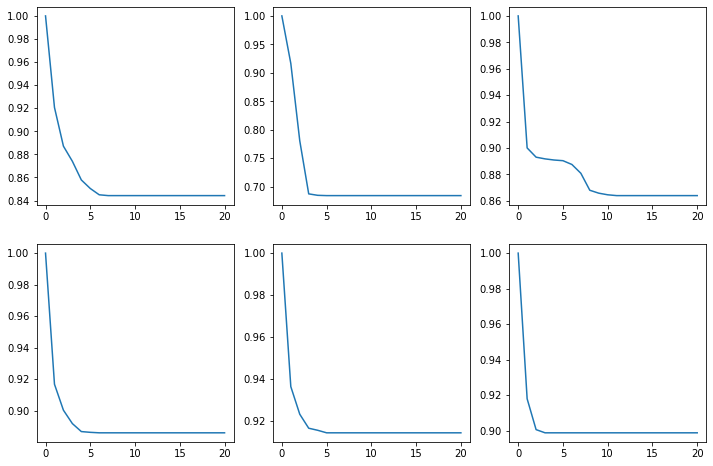

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(2):
    for j in range(3):
        ax[i, j].plot(warp_losses[i, j, 0]/warp_losses[i, j, 0][0])

In [20]:
warp_losses[0, 0, 0]

[0.8340329227894974,
 0.7678378992173626,
 0.7398640613902676,
 0.7289340303333368,
 0.7154387707148024,
 0.7092705865834397,
 0.7047172549782762,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844,
 0.7041292444924844]

In [ ]:
# Plot alignment losses


In [37]:
from sklearn.preprocessing import StandardScaler

Processing spikes


100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.11: 100%|██████████| 10/10 [00:00<00:00, 972.86it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 1256.83it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 30.29it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.11: 100%|██████████| 10/10 [00:00<00:00, 2644.91it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.11: 100%|██████████| 10/10 [00:00<00:00, 1265.63it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.09: 100%|██████████| 10/10 [00:00<00:00, 1795.28it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34.34it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.12: 100%|██████████| 10/10 [00:00<00:00, 2224.50it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 37.38it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2589.72it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29.88it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2280.38it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 32.11it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.11: 100%|██████████| 10/10 [00:00<00:00, 2219.33it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 38.38it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.12: 100%|██████████| 10/10 [00:00<00:00, 1270.31it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 32.02it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 1790.83it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31.79it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.09: 100%|██████████| 10/10 [00:00<00:00, 2022.33it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 21.42it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.12: 100%|██████████| 10/10 [00:00<00:00, 2260.23it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.58it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.09: 100%|██████████| 10/10 [00:00<00:00, 1841.71it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.09: 100%|██████████| 10/10 [00:00<00:00, 2282.61it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31.34it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.09: 100%|██████████| 10/10 [00:00<00:00, 1916.43it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29.00it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.09: 100%|██████████| 10/10 [00:00<00:00, 2385.16it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 30.71it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2472.91it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 30.37it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2227.22it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.53it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2329.39it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 20.11it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2396.47it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.67it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2511.56it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28.77it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2152.80it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31.26it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2072.39it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 26.22it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.11: 100%|██████████| 10/10 [00:00<00:00, 2009.34it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 20.93it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.10: 100%|██████████| 10/10 [00:00<00:00, 2195.17it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 20.75it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.09: 100%|██████████| 10/10 [00:00<00:00, 2162.24it/s]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 19.76it/s]
../../segmentation.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
Loss: 0.11: 100%|██████████| 10/10 [00:00<00:00, 1920.91it/s]


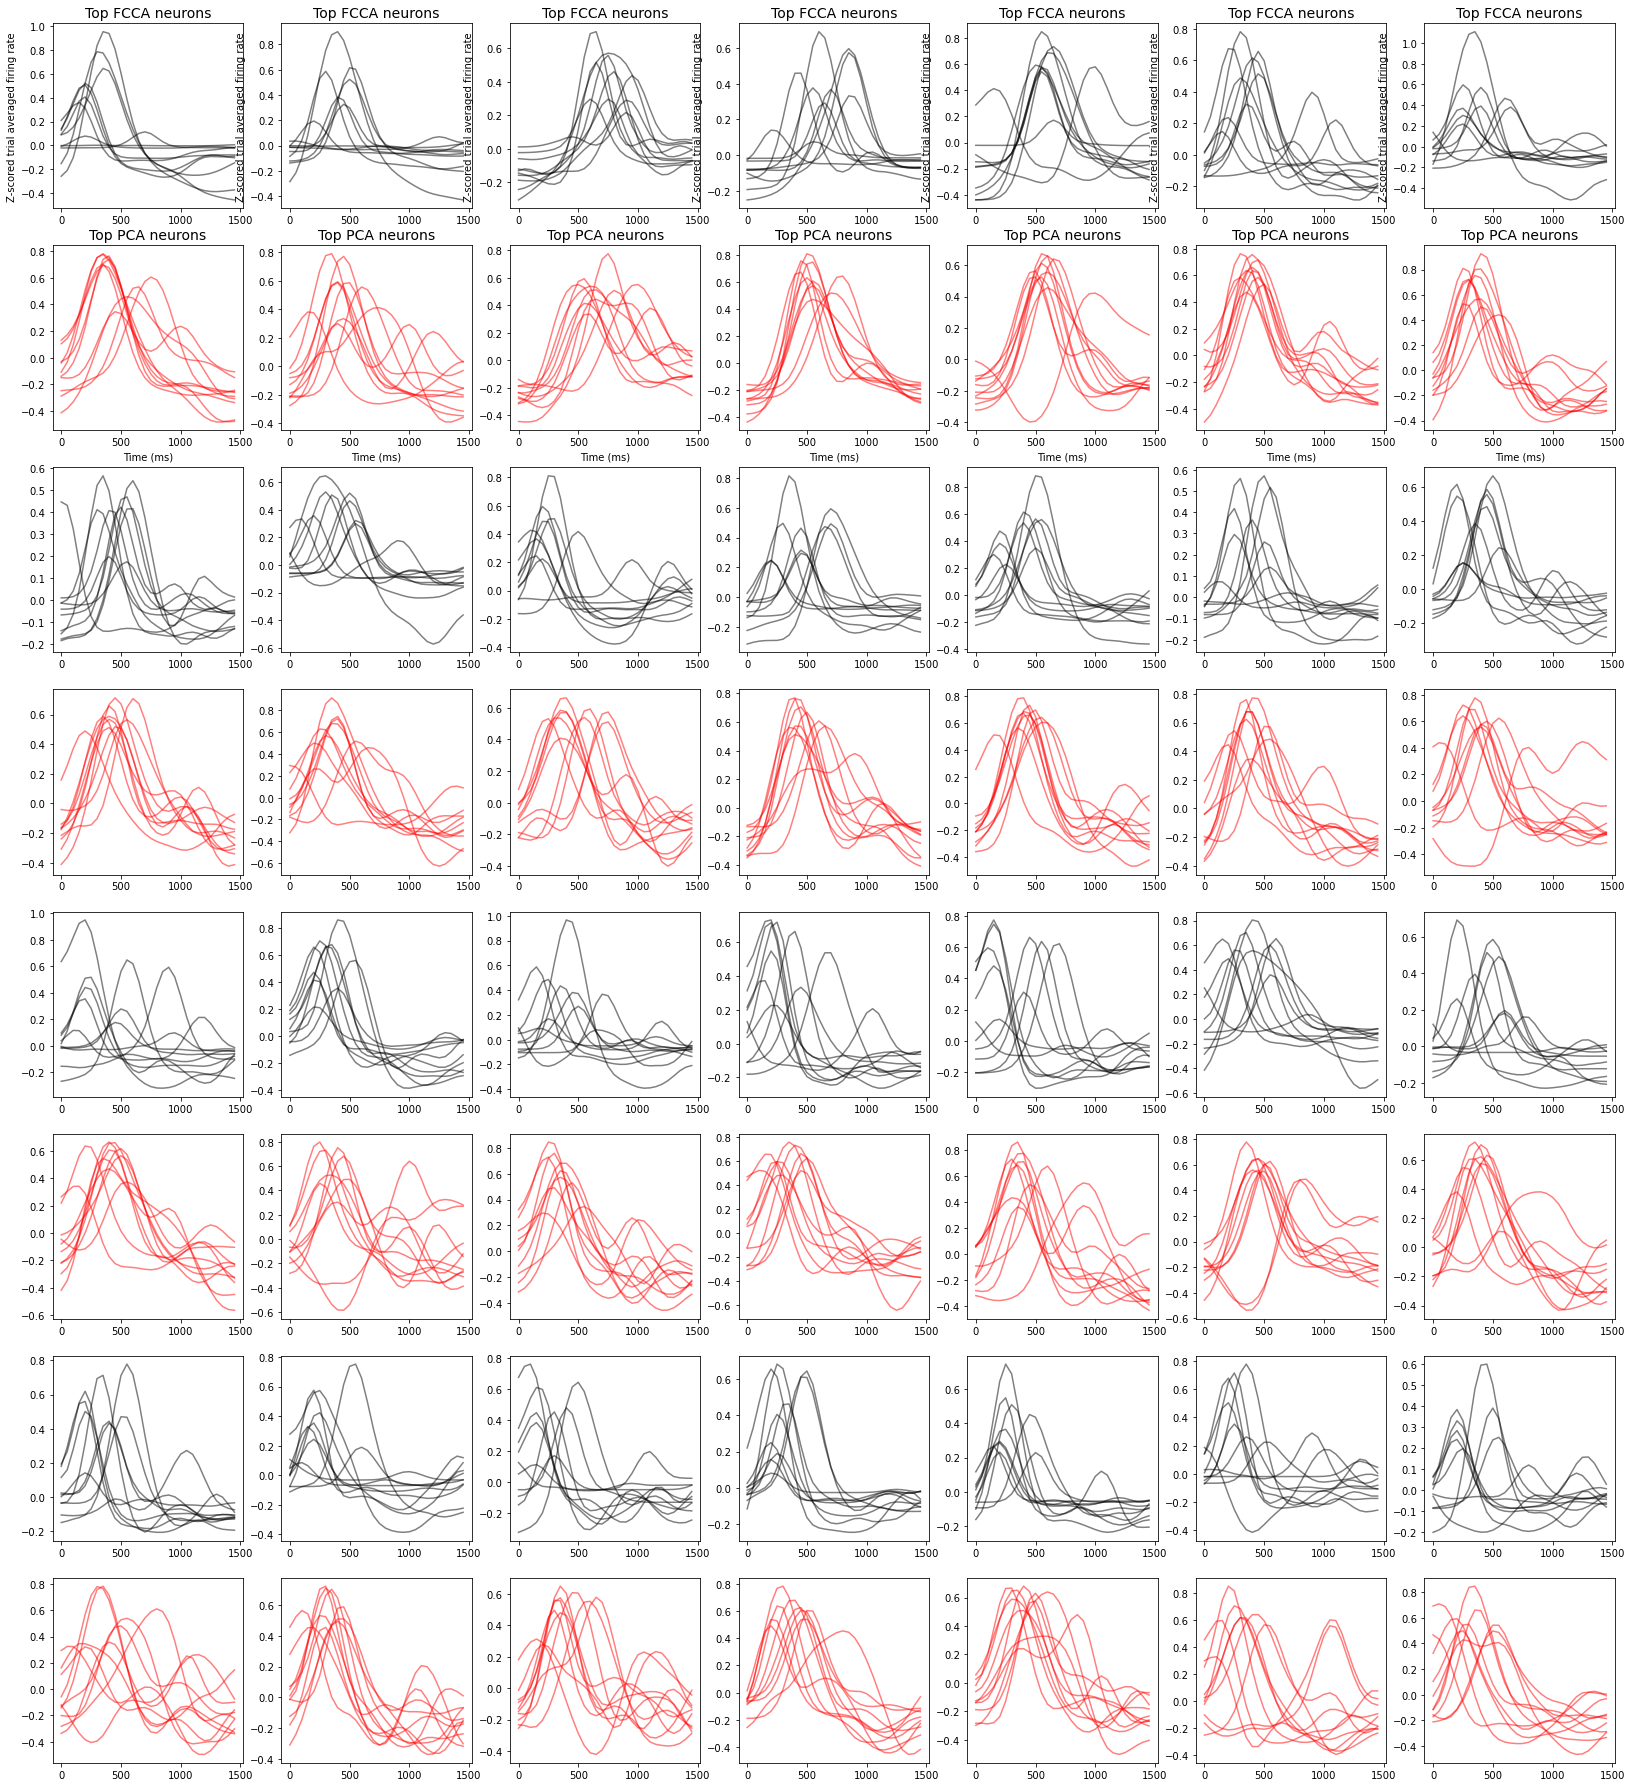

In [59]:
ndf = 7
fig, ax = plt.subplots(2 * 4, ndf, figsize=(4*ndf, 32))

for h, data_file in enumerate(data_files):

    df_ = apply_df_filters(top_neurons_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
    dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])
    
    T = 30
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]

    # (Bin size 50 ms)
    time = 50 * np.arange(30)

    for i in range(2):
        for j in range(n):
            tn = df_.iloc[0]['top_neurons'][i, j]    
            try:
                x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                            for idx in valid_transitions])
            except:
                pdb.set_trace()
            
            # Mean subtract
#            x_ -= np.mean(x_, axis=1, keepdims=True)
            x_ = StandardScaler().fit_transform(x_.T).T
            x_ = gaussian_filter1d(x_, sigma=2)

            swarp = ShiftWarping(maxlag=0.25,  smoothness_reg_scale=1)
            swarp.fit(x_[..., np.newaxis], iterations=10)

            x_ = np.squeeze(swarp.transform(x_[..., np.newaxis]))
            x_ = np.mean(x_, axis=0)


            if i == 0:
                ax[2 * (h//7) + i, h % 7].plot(time, x_, 'k', alpha=0.5)
            if i == 1:
                ax[2 * (h//7) + i, h % 7].plot(time, x_, 'r', alpha=0.5)

for i in range(ndf):
    ax[0, i].set_title('Top FCCA neurons', fontsize=14)
    ax[1, i].set_title('Top PCA neurons', fontsize=14)
    ax[1, i].set_xlabel('Time (ms)')
    ax[0, i].set_ylabel('Z-scored trial averaged firing rate')

fig.savefig('psth_indy_aligned.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Try the same thing but with time alignmentndf = 5
ndf = 5
fig, ax = plt.subplots(2, ndf, figsize=(4*ndf, 8))

for h, data_file in enumerate(data_files[0:ndf]):

    df_ = apply_df_filters(top_neurons_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=True)
    dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])
    
    T = 30
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]

    for i in range(2):
        for j in range(n):
            tn = df_.iloc[0]['top_neurons'][i, j]    
            x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                        for idx in valid_transitions])
            
            # Mean subtract
            x_ = gaussian_filter1d(x_, sigma=2)

            x_ -= np.mean(x_, axis=1, keepdims=True)
 #           x_ /= np.std(x_, axis=1, keepdims=True)

            # Time warp
            swarp = ShiftWarping(maxlag=0.25,  smoothness_reg_scale=1)
            swarp.fit(x_[..., np.newaxis], iterations=10)

            x_ = np.squeeze(swarp.transform(x_[..., np.newaxis]))
            x_ = np.mean(x_, axis=0)
            ax[i, h].plot(time, x_, 'g', alpha=0.5)

    ax[0, h].set_title('Top FCCA neurons', fontsize=14)
    ax[1, h].set_title('Top PCA neurons', fontsize=14)
    ax[1, h].set_xlabel('Time (ms)')
    ax[0, h].set_ylabel('Z-scored trial averaged firing rate')

fig.savefig('psth_aligned_indy.pdf', bbox_inches='tight', pad_inches=0)